In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
%matplotlib inline

np.random.seed(0)

In [4]:
#prepare training, testing and validation data

with open('/content/german-traffic-signs/train.p','rb') as f:
    train_data=pickle.load(f)
with open('/content/german-traffic-signs/test.p','rb') as f:
    test_data=pickle.load(f)
with open('/content/german-traffic-signs/valid.p','rb') as f:
    val_data=pickle.load(f)


In [6]:
#define features and corresponding labels

X_train,y_train= train_data['features'],train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [8]:
print(X_train.shape[-1])

3


In [9]:
data=pd.read_csv('/content/german-traffic-signs/signnames.csv')

(32, 32, 3)
36


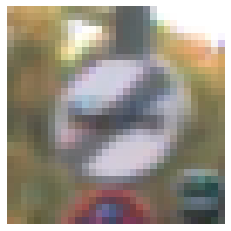

In [10]:

plt.imshow(X_train[100])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

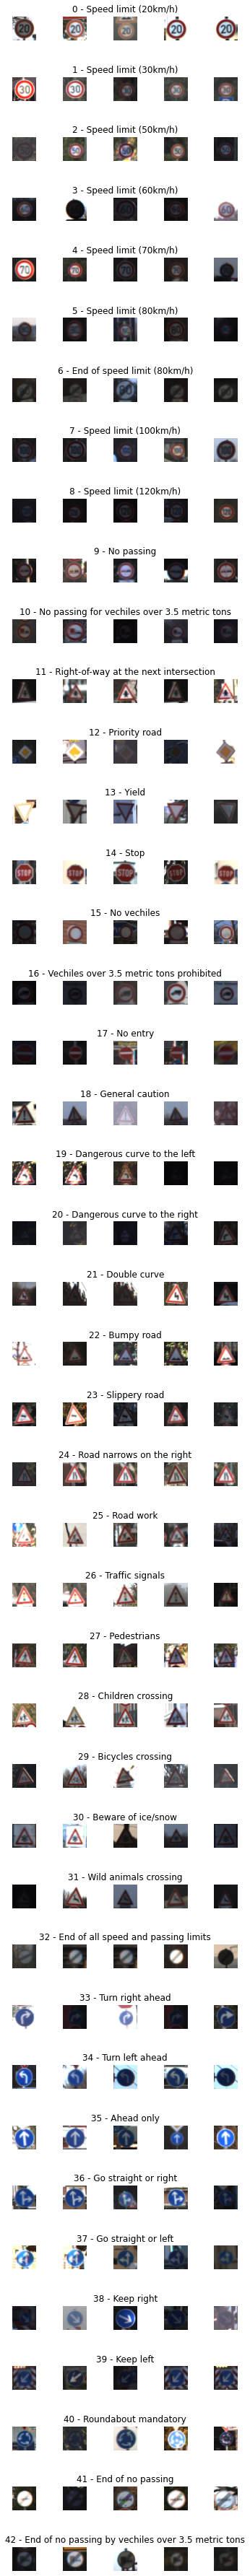

In [11]:
#plot on a grid

num_of_samples=[]

cols = 5
num_classes = 43

fig,axs=plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected= X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i==2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))
        
    

In [12]:
#convert to grayscale

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img



(32, 32)


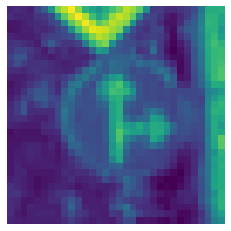

In [13]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)


In [14]:
#Histogram equalization

def equalize(img):
    img = cv2.equalizeHist(img)
    return img


(32, 32)


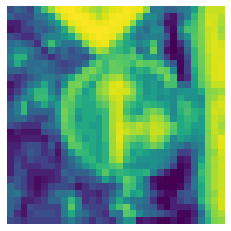

In [15]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [16]:
#preprocessing 

def preprocess(img):
    img=grayscale(img)
    img=equalize(img)
    img=img/255
    return img


In [17]:
#apply preprocessing to all images in X_train,X_test and X_val

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))


(34799, 32, 32)


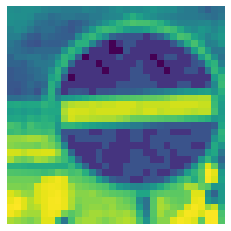

In [18]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)


In [19]:
X_train=X_train.reshape(34799, 32, 32,1)
X_test=X_test.reshape(12630, 32, 32,1)
X_val=X_val.reshape(4410, 32, 32,1)

In [20]:
print(X_train.shape)

(34799, 32, 32, 1)


(15, 32, 32, 1)


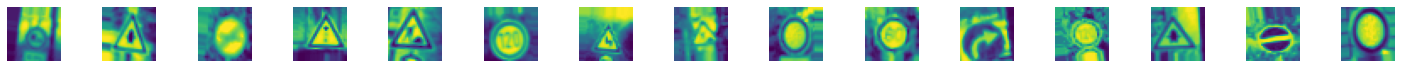

In [21]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

# for X_batch, y_batch in

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)



In [22]:
#prepare labels

y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [23]:
print(y_val[0].shape)

(43,)


In [24]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(130, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Flatten())
    model.add(Dense(130, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
  
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model= modified_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 130)       149890    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 130)        0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
train_datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)


In [27]:
train_it = train_datagen.flow(X_train, y_train, batch_size=74)

In [28]:
print(len(train_it))

471


In [29]:
history = model.fit_generator(train_it, steps_per_epoch=720,validation_data=(X_val, y_val),
                              epochs=15,shuffle = 1)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


471/720 [==================>...........] - ETA: 2:01 - loss: 2.4880 - accuracy: 0.3088WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10800 batches). You may need to use the repeat() function when building your dataset.


720/720 [==============================] - 237s 328ms/step - loss: 2.4880 - accuracy: 0.3088 - val_loss: 0.7512 - val_accuracy: 0.7592


In [30]:
model.save('traffic_prediction2.h5')

Text(0.5, 0, 'epoch')

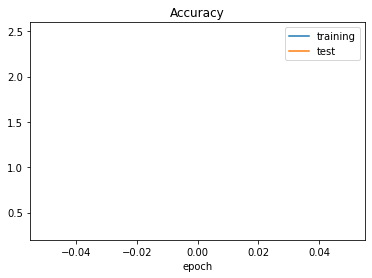

In [31]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [32]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
%matplotlib inline

np.random.seed(0)
model = load_model('traffic_prediction2.h5')

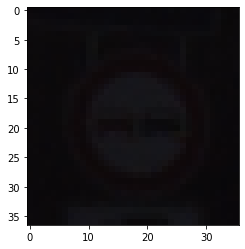

In [47]:
img = Image.open('/content/drive/MyDrive/Test/00063.png')
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(32, 32)


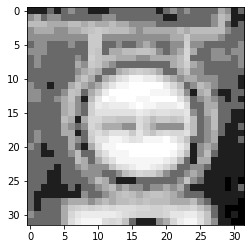

In [49]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [50]:
img = img.reshape(1, 32, 32, 1)
test = model.predict(img)
classes_x=np.argmax(test,axis=1)
print("predicted sign: "+ str(classes_x))


predicted sign: [9]


In [40]:
ls

drive/  german-traffic-signs/  sample_data/  traffic_prediction2.h5
